In [1]:
##imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from interpret.glassbox import ExplainableBoostingClassifier

In [2]:
valid_Xs = pd.read_csv("../preprocessed_data/valid_Xs.csv")
valid_ys = pd.read_csv("../preprocessed_data/valid_ys.csv")

train_Xs = pd.read_csv("../preprocessed_data/train_Xs.csv")
train_ys = pd.read_csv("../preprocessed_data/train_ys.csv")

def relevel_gd(df):
    df.loc[df['goal_diff']>3, 'goal_diff'] = 3
    df.loc[df['goal_diff']<-3, 'goal_diff'] = -3
    return df

valid_Xs = relevel_gd(valid_Xs)
train_Xs = relevel_gd(train_Xs)

In [3]:
train_Xs.head()

,dist_to_goal,angle_to_goal,end_x,last_action_succ,last_action_foul,goal_diff,forward_movt_l,forward_movt_l2,forward_movt_l3,time_del_l1_l3
0,66.055996,3.281017,39.585,1,0,0,1.995,0.420,-8.505,1.8
1,60.861846,3.358936,45.570,1,0,0,-4.935,1.995,0.420,1.8
2,56.672567,3.359286,49.665,1,0,0,-4.095,-4.935,1.995,1.8
3,71.963646,3.339424,34.440,1,0,0,8.085,-4.095,-4.935,1.8
4,75.286424,2.982864,30.660,1,0,0,-11.130,8.085,-4.095,1.8


In [4]:
%%time

models = {}
for col in ["scoring", "conceding"]:
    ebm = ExplainableBoostingClassifier(interactions=3, random_state=42, validation_size=0.2)
    ebm.fit(train_Xs, train_ys[col])
    models[col] = ebm

Wall time: 3min 32s


In [5]:
scoring_probs = models["scoring"].predict_proba(valid_Xs)[:, 1]
conceding_probs = models["conceding"].predict_proba(valid_Xs)[:, 1]

vaep_values = scoring_probs - conceding_probs

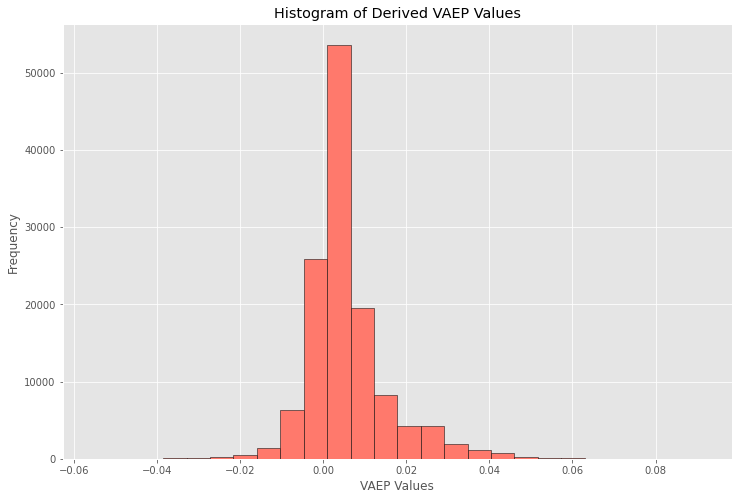

In [13]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(vaep_values, bins=26, ec="k", fc="xkcd:salmon")
    ax.set(xlabel="VAEP Values", ylabel="Frequency", title="Histogram of Derived VAEP Values")
    fig.savefig("vaep_values", dpi=150)

In [7]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2287686489808/ -->

In [ ]:
ebm.explain_global()

#### Model Evaluation

In [10]:
from sklearn.metrics import brier_score_loss

model_name = "scoring"
predicted_probs = models[model_name].predict_proba(valid_Xs)[:, 1]

baseline_preds = np.ones(len(valid_ys))*valid_ys[model_name].mean() ##according to the paper predicting all values as the class distribution
baseline_brier_score = brier_score_loss(valid_ys[model_name].values, baseline_preds)

print(f"Baseline Prediction Brier Score: {baseline_brier_score:.5f}")

model_brier_score = brier_score_loss(valid_ys[model_name].values, predicted_probs)
print(f"Model Brier Score: {model_brier_score:.5f}")

normalized_brier_score_loss = model_brier_score/baseline_brier_score
print(f"Normalized Brier Score: {normalized_brier_score_loss:.5f}") ##lower=better; 0 = perfect, >1 equals bogus, <1 is okay

Baseline Prediction Brier Score: 0.01073
Model Brier Score: 0.01071
Normalized Brier Score: 0.99847


In [8]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=ebm.predict_proba, data=train_Xs)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

<!-- http://127.0.0.1:7001/2287713682240/ -->

In [30]:
from xgboost import XGBClassifier

In [32]:
xgb_model = XGBClassifier(random_state=42).fit(train_Xs.values, train_ys["scoring"].values)

In [34]:
from sklearn.metrics import brier_score_loss

model_name = "scoring"
predicted_probs = xgb_model.predict_proba(valid_Xs.values)[:, 1]

baseline_preds = np.ones(len(valid_ys))*valid_ys[model_name].mean() ##according to the paper predicting all values as the class distribution
baseline_brier_score = brier_score_loss(valid_ys[model_name].values, baseline_preds)

print(f"Baseline Prediction Brier Score: {baseline_brier_score:.5f}")

model_brier_score = brier_score_loss(valid_ys[model_name].values, predicted_probs)
print(f"Model Brier Score: {model_brier_score:.5f}")

normalized_brier_score_loss = model_brier_score/baseline_brier_score
print(f"Normalized Brier Score: {normalized_brier_score_loss:.5f}") ##lower=better; 0 = perfect, >1 equals bogus, <1 is okay

Baseline Prediction Brier Score: 0.01073
Model Brier Score: 0.01077
Normalized Brier Score: 1.00429
